In [0]:
!pip install -q tf_nightly

In [117]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras.models import Model
from keras.layers import Dense, Dropout, Input, GlobalMaxPooling1D, Convolution1D, Embedding,SpatialDropout1D
from keras.layers.merge import Concatenate
from keras.preprocessing import sequence
from keras import regularizers
from keras.utils import plot_model
print(tf.__version__)


np.random.seed(0)

# ---------------------- Parameters section -------------------
#
# See Kim Yoon's Convolutional Neural Networks for Sentence Classification


class hyper():
  def __init__(self,embedding_dim,filter_sizes,num_filters,dropout_prob,hidden_dims,batch_size,num_epochs):
    # Model Hyperparameters
    self.embedding_dim = embedding_dim
    self.filter_sizes = filter_sizes
    self.num_filters = num_filters
    self.dropout_prob = dropout_prob
    self.hidden_dims = hidden_dims
    # Training parameters
    self.batch_size = batch_size
    self.num_epochs = num_epochs

class prep_hyper():
  def __init__(self,sequence_length,max_words):
    # Prepossessing parameters
    self.sequence_length = sequence_length
    self.max_words = max_words
    
m_hyper=hyper(embedding_dim=50,filter_sizes=(3,4,5,6,8),num_filters=100,dropout_prob=(0.2,0.5),hidden_dims=50,batch_size=64,num_epochs= 3)

pr_hyper = prep_hyper(sequence_length=400,max_words=5000)

1.14.0


In [0]:
def load_imdb_data(pr_hyper):
  imdb = keras.datasets.imdb
  (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=pr_hyper.max_words, start_char=None,
                                                              oov_char=None, index_from=None)

  x_train = sequence.pad_sequences(x_train, maxlen=pr_hyper.sequence_length, padding="post", truncating="post")
  x_test = sequence.pad_sequences(x_test, maxlen=pr_hyper.sequence_length, padding="post", truncating="post")

  vocabulary = imdb.get_word_index()
  vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
  vocabulary_inv[0] = "<PAD/>"
  return x_train, y_train, x_test, y_test, vocabulary_inv

In [119]:
# Data Preparation
print("Load data...")
x_train, y_train, x_test, y_test, vocabulary_inv = load_imdb_data(pr_hyper)

Load data...


In [120]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

x_train shape: (25000, 400)
x_test shape: (25000, 400)
Vocabulary Size: 88585


In [0]:
def build_model(pr_hyper,m_hyper):
    
    # Convolutional block
    model_input = Input(shape=(pr_hyper.sequence_length,),dtype='int32')
    # use a random embedding for the text
    x = Embedding(pr_hyper.max_words, m_hyper.embedding_dim)(model_input)
    x = SpatialDropout1D(m_hyper.dropout_prob[0])(x)

    conv_kern_reg = regularizers.l2(0.00001)
    conv_bias_reg = regularizers.l2(0.00001)
    
    conv_blocks = []
    for sz in m_hyper.filter_sizes:
        conv = Convolution1D(filters=m_hyper.num_filters,
                             kernel_size=sz,
                             padding="same",
                             activation="relu",
                             strides=1,
                             kernel_regularizer=conv_kern_reg,
                             bias_regularizer=conv_bias_reg)(x)
        conv = GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)
    # merge
    x = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    
    x = Dropout(m_hyper.dropout_prob[1])(x)
    x = Dense(m_hyper.hidden_dims, activation="relu")(x)
    model_output = Dense(1, activation="sigmoid")(x)
    model = Model(model_input, model_output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [122]:
# Train the model
model=build_model(pr_hyper,m_hyper)
history = model.fit(x_train, y_train, batch_size=m_hyper.batch_size, epochs=m_hyper.num_epochs,
          validation_data=(x_test, y_test), verbose=1)
history_dict = history.history

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 400, 50)      250000      input_17[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_11 (SpatialDr (None, 400, 50)      0           embedding_17[0][0]               
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 400, 100)     15100       spatial_dropout1d_11[0][0]       
__________________________________________________________________________________________________
conv1d_57 

In [123]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9646
Testing Accuracy:  0.8903


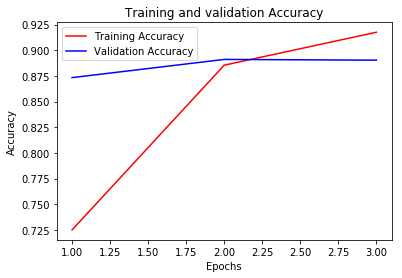

In [124]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'r', label='Training Accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()